# Loan Application 

In [1]:
# Import module

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv('LoanApplication.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
#loan ID is not significant, we can drop it at the first place
data= data.drop(['Loan_ID'], axis = 1)

In [4]:
#check data type
data.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
# Credit_History is a categorical feature with value 0 and 1
data.Credit_History = data.Credit_History.astype('object')

In [8]:
# convert Total_Income to numeric
data['Total_Income'] = data.Total_Income.str.replace('$','').astype(float)

AttributeError: 'DataFrame' object has no attribute 'Total_Income'

In [9]:
#statistical summary
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


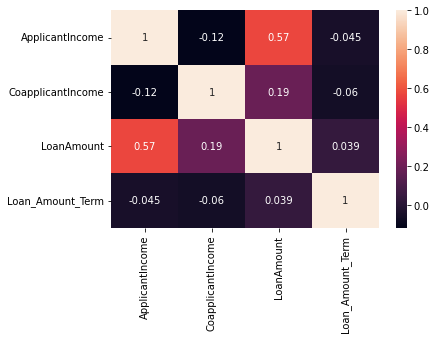

In [11]:
# Check correction between numberic features
sns.heatmap(data.select_dtypes(include = np.number).corr(),annot = True)
# Drop ApplicantIncome since it has a high correction with Total_Income
data = data.drop(['ApplicantIncome'], axis = 1)

In [15]:
''' Check outliers for numeric features (CoapplicantIncome,
LoanAmount, Loan_Amount_Term,  Total_Income)'''


lis = ['CoapplicantIncome','LoanAmount', 'Loan_Amount_Term']
for i in lis:
    mean = np.mean(data[i])
    std = np.std(data[i])
    
    upper = mean +3*std
    lower = mean-3*std
    
    
    print(i,'Upper boundry is:',math.ceil(upper), ';','Lower boundry is:',math.ceil(lower))

CoapplicantIncome Upper boundry is: 10393 ; Lower boundry is: -7150
LoanAmount Upper boundry is: 403 ; Lower boundry is: -110
Loan_Amount_Term Upper boundry is: 538 ; Lower boundry is: 147


In [17]:
data.shape

(614, 11)

In [18]:
#checking missing values
data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [19]:
# Apply different method for missing value
data.dropna(subset =['Gender','Married'], how = 'any', inplace = True)
data.Dependents.fillna(data.Dependents.mode()[0],inplace = True) 
data.LoanAmount.fillna(data.LoanAmount.mean(),inplace = True )
data.Loan_Amount_Term.fillna(data.Loan_Amount_Term.median(),inplace = True)
data.Credit_History.fillna(0,inplace = True)
data.Self_Employed.fillna(data['Self_Employed'].mode()[0],inplace= True)

In [20]:
label = LabelEncoder().fit_transform(data.Loan_Status)

In [21]:
data['Loan_Status'] = label
data.head()

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,0.0,144.968804,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,0.0,141.000000,360.0,1.0,Urban,1


In [22]:
X = data.drop('Loan_Status', axis =1)
y = label

In [23]:
ohe = OneHotEncoder()
oe = OrdinalEncoder()
stand = StandardScaler()


col_transform = make_column_transformer(
        (ohe,['Gender', 'Married',  'Self_Employed','Credit_History','Property_Area'])
       ,(oe,['Dependents','Education'])
       ,(stand,['CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term']))

col_transform.fit_transform(X)[0]

array([ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -5.52892352e-01, -3.50156406e-16,  2.74031363e-01])

In [24]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state = 0)

In [25]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(448, 10)
(448,)
(150, 10)
(150,)


[0.7466666666666667, 0.74, 0.74, 0.7266666666666667, 0.7466666666666667, 0.7333333333333333, 0.7333333333333333, 0.74, 0.74, 0.74, 0.7466666666666667, 0.74, 0.7466666666666667, 0.74, 0.7266666666666667]


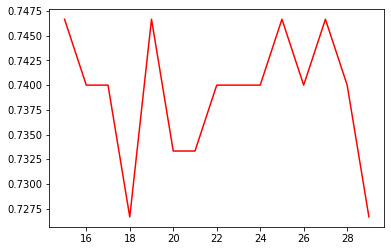

In [26]:
# 22 is the best k
score =[]
for i in range(15,30):
    knn = KNN(n_neighbors = i)
    knnpipe = make_pipeline(col_transform,knn).fit(Xtrain,ytrain)
    once = knnpipe.score(Xtest,ytest)
    score.append(once)
    
print(score)
plt.plot(range(15,30),score, color = 'red')
plt.show()

In [27]:
# Put different models' results in a dataframe

from tabulate import tabulate

models = []
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('LogisticRegression', LR(C = 0.8)))
models.append(('SVM', SVC()))
models.append(('KNN',KNN(n_neighbors = 22,weights='distance')))

result = []
i = 0

for name, model in (models):
    pipe = make_pipeline(col_transform,model)
    pipe.fit(Xtrain,ytrain)
    ypre = pipe.predict(Xtest)
    report = classification_report(ytest, ypre,output_dict=True)
    result.append(report)
    
   
    df = pd.DataFrame(result[i]).transpose()
    i += 1
    print('\n')
    print(name)
    print(tabulate(df.round(2), showindex = True, headers = df.columns))


ModuleNotFoundError: No module named 'tabulate'